In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pickle

In [2]:
from tensorflow.keras.models import load_model

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

In [4]:
import ipywidgets as widgets
from ipywidgets import interact, fixed

# 1. Nuages de mots

## 1.1. Load corpus

In [5]:
with open("results/corpus_bad", "rb") as fp:
    corpus_bad = pickle.load(fp)

In [6]:
with open("results/corpus_good", "rb") as fp:
    corpus_good = pickle.load(fp)

In [7]:
with open("results/corpus_sample", "rb") as fp:
    corpus_sample = pickle.load(fp)

## 1.2. First WordCloud

In [8]:
wordcloud_bad = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_bad))

In [9]:
wordcloud_good = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_good))

In [10]:
wordcloud_sample = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_sample))

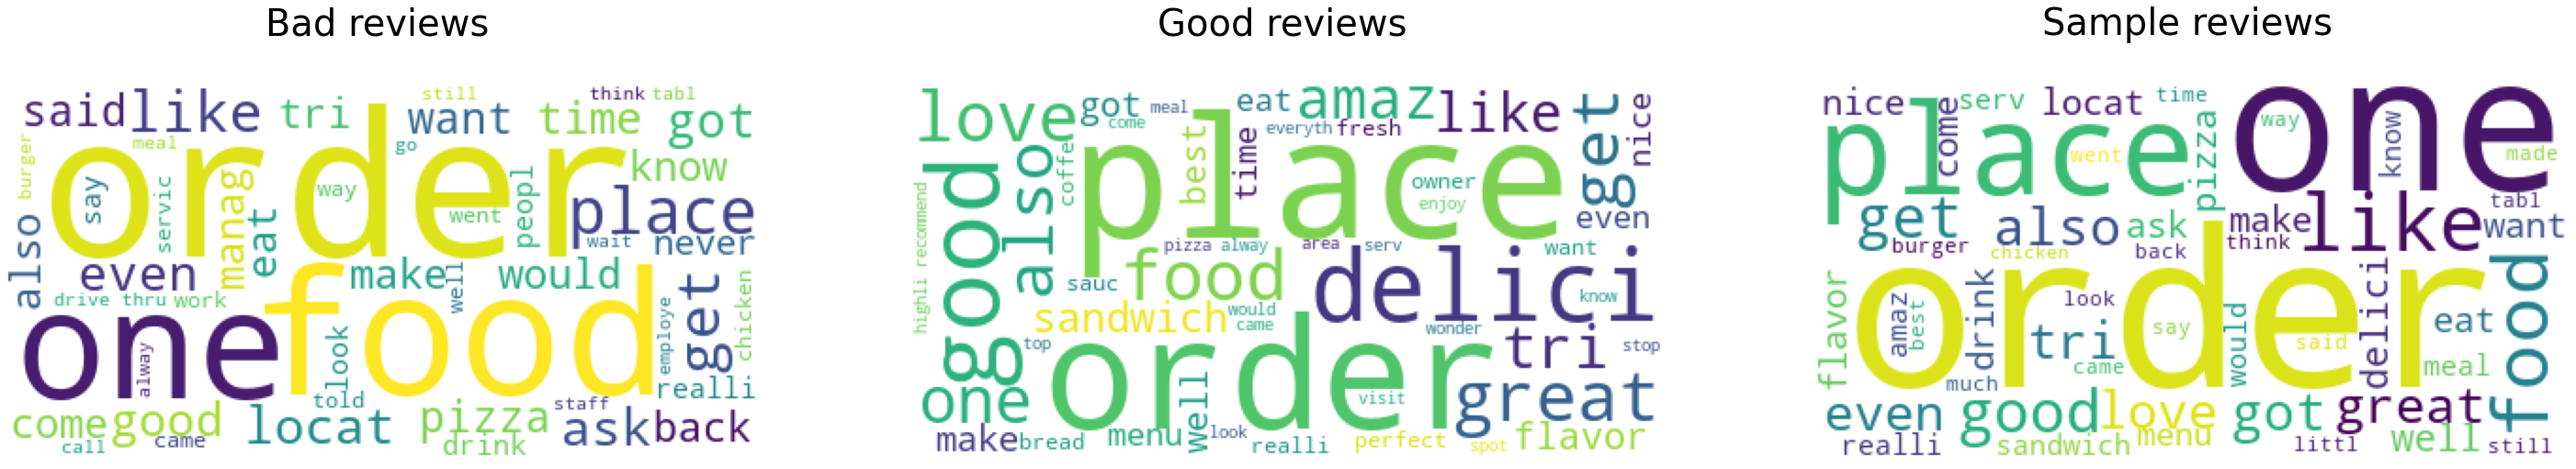

In [11]:
fig = plt.figure(figsize=(50,20))
ax1 = fig.add_subplot(131)
ax1.set_title('Bad reviews \n', fontdict={'fontsize': 40})
plt.imshow(wordcloud_bad)
plt.axis("off")

ax2 = fig.add_subplot(132)
ax2.set_title('Good reviews \n', fontdict={'fontsize': 40})
plt.imshow(wordcloud_good)
plt.axis("off")

ax3 = fig.add_subplot(133)
ax3.set_title('Sample reviews \n', fontdict={'fontsize': 40})
plt.imshow(wordcloud_sample)
plt.axis("off")

plt.show()

## 1.3. WordCloud without Context

In [13]:
N_WORD_IN_CONTEXT = 20
doublons = [i for i in pd.Series(corpus_bad).value_counts().head(N_WORD_IN_CONTEXT).index
            if i in pd.Series(corpus_good).value_counts().head(N_WORD_IN_CONTEXT).index]
doublons

['order',
 'food',
 'time',
 'get',
 'place',
 'one',
 'like',
 'servic',
 'good',
 'back']

In [14]:
with open("results/corpus_bad_context", "rb") as fp:
    corpus_bad_context = pickle.load(fp)

In [15]:
with open("results/corpus_good_context", "rb") as fp:
    corpus_good_context = pickle.load(fp)

In [16]:
with open("results/corpus_sample_context", "rb") as fp:
    corpus_sample_context = pickle.load(fp)

In [17]:
wordcloud_bad_context = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_bad_context))

In [18]:
wordcloud_good_context = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_good_context))

In [19]:
wordcloud_sample_context = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_sample_context))

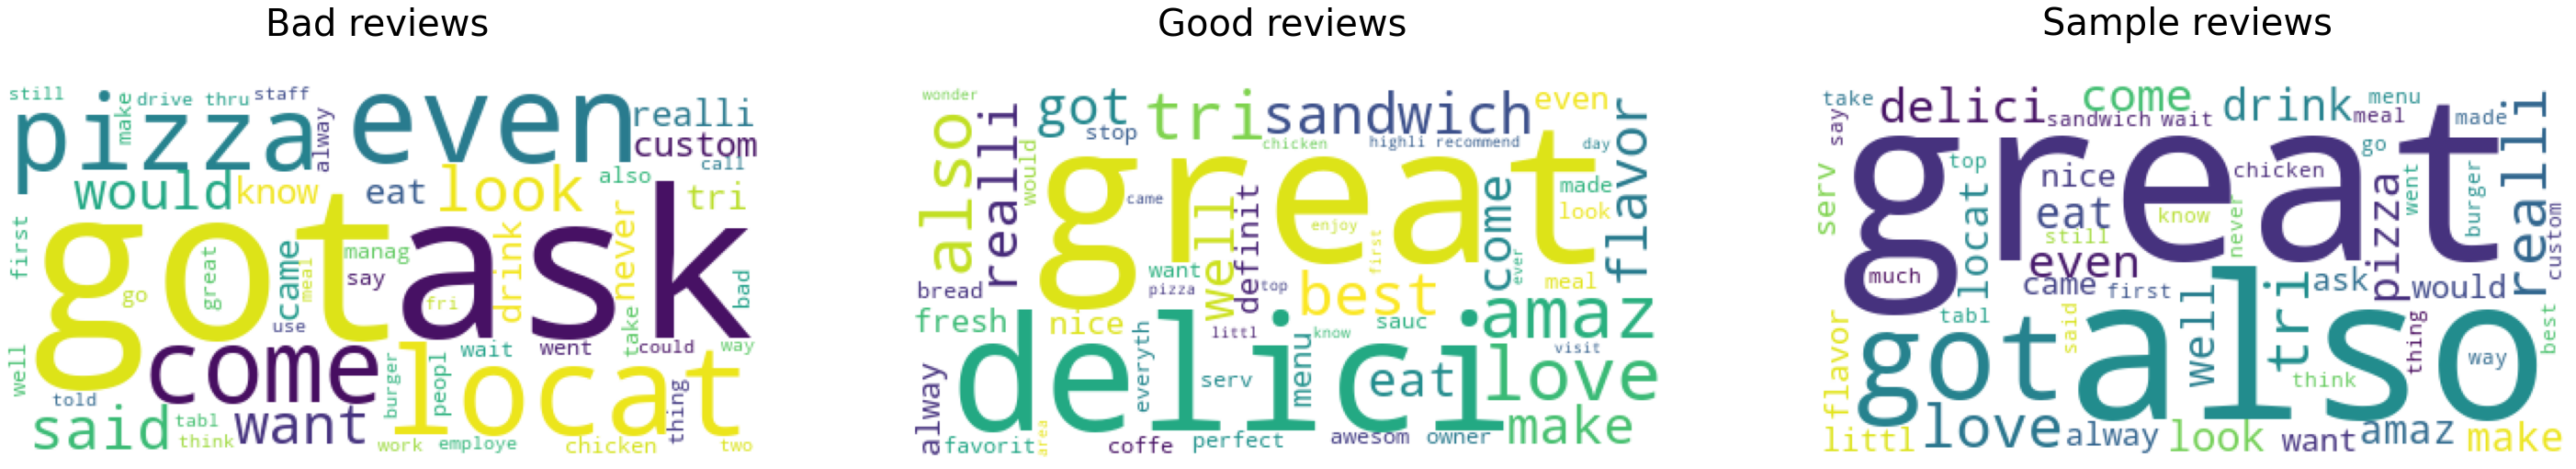

In [20]:
fig = plt.figure(figsize=(50,20))

ax1 = fig.add_subplot(131)
ax1.set_title('Bad reviews \n', fontdict={'fontsize': 40})
plt.imshow(wordcloud_bad_context)
plt.axis("off")

ax2 = fig.add_subplot(132)
ax2.set_title('Good reviews \n', fontdict={'fontsize': 40})
plt.imshow(wordcloud_good_context)
plt.axis("off")

ax3 = fig.add_subplot(133)
ax3.set_title('Sample reviews \n', fontdict={'fontsize': 40})
plt.imshow(wordcloud_sample_context)
plt.axis("off")

plt.show()

# 2. Sujet d'insatisfaction avec LDA

In [21]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## 2.1. Choix du nombre de topics

In [85]:
with open("results/coherence", "rb") as fp:
    coherence_df = pickle.load(fp)

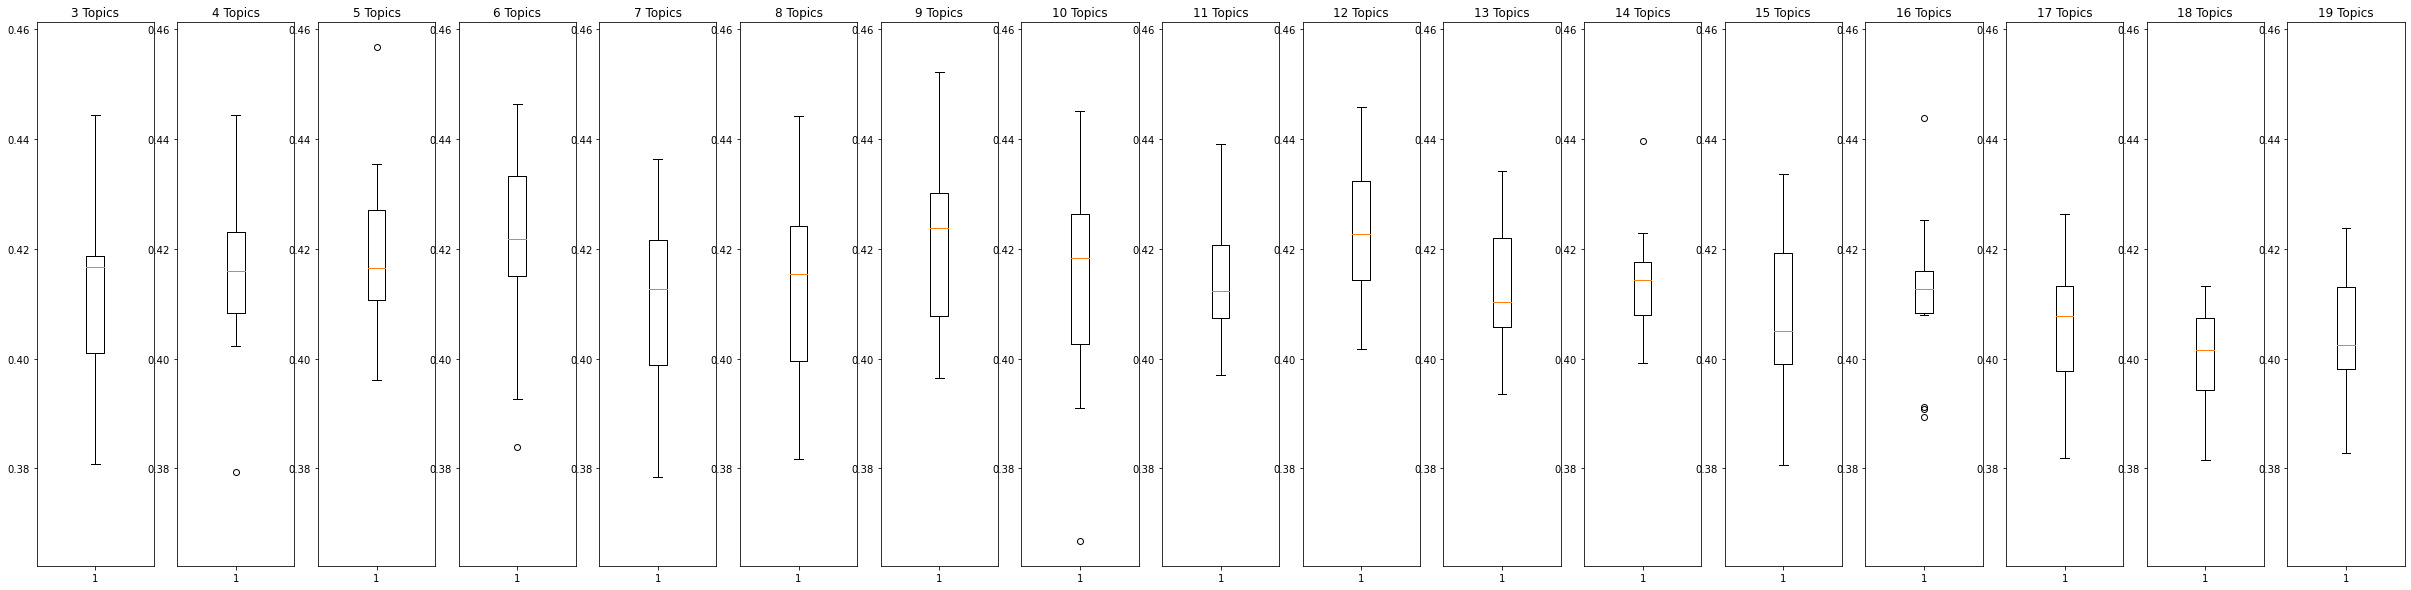

In [87]:
fig = plt.figure(figsize=(50,10))

ax1 = fig.add_subplot(1, 20, 1)
ax1.set_title('3 Topics', fontdict={'fontsize': 12})
plt.boxplot(coherence_df[3].dropna().values)


for i in range(4,20):
    ax = fig.add_subplot(1, 20, i-2, sharey=ax1)
    ax.set_title(f'{i} Topics', fontdict={'fontsize': 12})
    plt.boxplot(coherence_df[i].dropna().values)

plt.show()

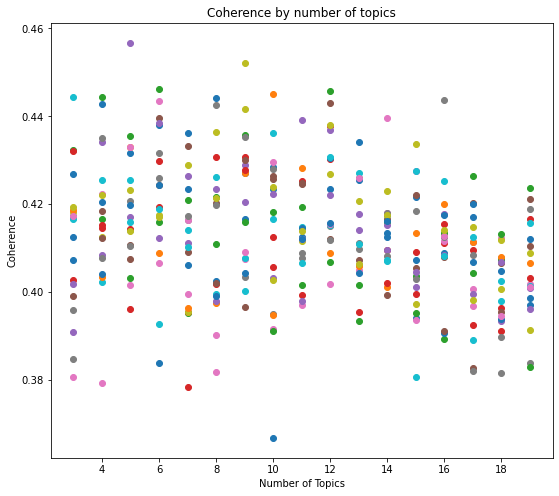

In [26]:
plt.figure(figsize=(9,8))
for k in range(0, coherence_df.shape[0]):
    plt.scatter(coherence_df.iloc[k].index, coherence_df.iloc[k].values)
plt.title('Coherence by number of topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.show()

Les résultats ne donnent pas un nombre de topics à privilégié.  
On voit seulement qu'au delà de 13 topics, les résultats sont moins bons.

## 2.2. Modélisation

In [60]:
from gensim.models import CoherenceModel, LdaMulticore
from gensim.corpora import Dictionary

from gensim import models

import pyLDAvis
import pyLDAvis.gensim_models 

In [61]:
with open("results/lda_texts", "rb") as fp:
    lda_texts = pickle.load(fp)

In [62]:
with open("results/lda_id2word", "rb") as fp:
    lda_id2word = pickle.load(fp)

In [63]:
with open("results/lda_corpus", "rb") as fp:
    lda_corpus = pickle.load(fp)

### 2.2.1. Best model : 5 topics

In [64]:
lda_best_model =  models.LdaModel.load('results/lda.model')
lda_best_model.num_topics

5

In [65]:
cm = CoherenceModel(model=lda_best_model, texts=lda_texts, dictionary=lda_id2word, coherence='c_v')
cm.get_coherence()

0.4567538530000631

In [67]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models .prepare(lda_best_model, lda_corpus, lda_id2word)
p

C:\Users\solmy\anaconda3\envs\MachineLearning\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.071337  0.019565       1        1  24.498346
1      0.130182  0.109978       2        1  23.506137
0     -0.039605 -0.070361       3        1  20.279194
2      0.101009 -0.103159       4        1  19.981907
4     -0.120249  0.043977       5        1  11.734416, topic_info=        Term         Freq        Total Category  logprob  loglift
374    pizza  1574.000000  1574.000000  Default  30.0000  30.0000
1       call  1000.000000  1000.000000  Default  29.0000  29.0000
93      tabl  1089.000000  1089.000000  Default  28.0000  28.0000
181  chicken  1535.000000  1535.000000  Default  27.0000  27.0000
196    minut  1914.000000  1914.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
351      got   171.651013  1899.436778   Topic5  -5.3764  -0.2612
94      take   156.317441  1116.843052   Topic5  -5.4699   0.1763
341   custom   154.368065  1174.940065   Topic5  -5.4825   0.1130
496     give   152.014887  1132.309203   Topic5  -5.4978   0.1346
171     wait   150.949545  2402.913272   Topic5  -5.5049  -0.6248

[426 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1457      2  0.254175    airport
1457      3  0.012924    airport
1457      4  0.732370    airport
4563      3  0.924695      alarm
3175      1  0.951230     allerg
...     ...       ...        ...
1041      4  0.014759      wrong
1041      5  0.147588      wrong
398       1  0.937353        wth
2922      1  0.975245  young_man
2922      3  0.027090  young_man

[1021 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3, 5])

Une analyse des mots par sujets d'insatisfaction ou cluster nous donne :

1. L'attente
2. Erreur de commande
3. Un problème de logistique ou les vendeurs
4. Le service à table
5. Des problèmes liés à des livraisons de pizzas

### 2.2.2. Performant model with 9 topics

In [68]:
lda_model_9 =  models.LdaModel.load('results/9_topics/lda.model')
lda_model_9.num_topics

9

In [69]:
cm = CoherenceModel(model=lda_model_9, texts=lda_texts, dictionary=lda_id2word, coherence='c_v')
cm.get_coherence()

0.44162166676202946

In [70]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models .prepare(lda_model_9, lda_corpus, lda_id2word)
p

C:\Users\solmy\anaconda3\envs\MachineLearning\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.028657  0.052996       1        1  12.986141
8      0.079655 -0.068863       2        1  12.789678
6      0.095202  0.087529       3        1  11.893227
7      0.142080 -0.007130       4        1  11.311078
1     -0.127957  0.028397       5        1  10.821952
4     -0.138224 -0.027806       6        1  10.324206
0     -0.099815  0.140760       7        1  10.134133
5      0.104751 -0.036379       8        1  10.126555
3     -0.084349 -0.169505       9        1   9.613030, topic_info=        Term         Freq        Total Category  logprob  loglift
374    pizza  1594.000000  1594.000000  Default  30.0000  30.0000
181  chicken  1517.000000  1517.000000  Default  29.0000  29.0000
171     wait  2409.000000  2409.000000  Default  28.0000  28.0000
274   burger   829.000000   829.000000  Default  27.0000  27.0000
1       call  1013.000000  1013.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
132     need   112.813934   991.313150   Topic9  -5.5967   0.1688
449      see   103.895468   712.800734   Topic9  -5.6790   0.4162
248   expect   103.057674   678.751075   Topic9  -5.6871   0.4571
141   servic   114.587836  2656.870650   Topic9  -5.5811  -0.8015
5       even   108.403289  1828.377559   Topic9  -5.6366  -0.4833

[730 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5760      3  0.950392       accus
1893      1  0.030204  acknowledg
1893      2  0.583937  acknowledg
1893      4  0.281901  acknowledg
1893      5  0.010068  acknowledg
...     ...       ...         ...
4002      3  0.064805         yum
4002      5  0.907263         yum
2185      3  0.194533   zero_star
2185      8  0.756519   zero_star
2185      9  0.021615   zero_star

[2315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 7, 8, 2, 5, 1, 6, 4])

Une analyse des mots par sujets d'insatisfaction ou cluster est plus complexe.  

On peut décrire  :

1. Erreur de commande
2. L'attente
3. Problèmes de livraisons de pizza
4. Problème du service drive
5. Problème avec des Fast food
6. Le rapport Qualité/prix
7. Erreur de commande
8. Le contact client
9. Des problèmes sur les endroits

# 3. Etiquettage des photos

## 3.1. SIFT et Clustering

In [110]:
with open("results/CV/sift_tsne", "rb") as fp:
    sift_tsne = pickle.load(fp)

In [111]:
with open("results/CV/sift_cm", "rb") as fp:
    sift_cm = pickle.load(fp)

In [112]:
colors = {
    'inside' : sns.color_palette('tab10', n_colors=5)[0],
    'outside' : sns.color_palette('tab10', n_colors=5)[1],
    'drink' : sns.color_palette('tab10', n_colors=5)[2],
    'food' : sns.color_palette('tab10', n_colors=5)[3],
    'menu' : sns.color_palette('tab10', n_colors=5)[4],
}


In [113]:
labels_elements = {
    'Intérieur': 'inside',
    'Extérieur': 'outside',
    'Menu': 'menu',
    'Nourriture': 'food',
    'Boisson': 'drink',
}
@interact(element=labels_elements)
def choix_element(element):
    sns.scatterplot(x="tsne1", y="tsne2", data=sift_tsne[sift_tsne["class"]==element], color=colors[element], s=50, alpha=0.6)

    plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    plt.legend(prop={'size': 14}) 

    plt.show()

interactive(children=(Dropdown(description='element', options={'Intérieur': 'inside', 'Extérieur': 'outside', …

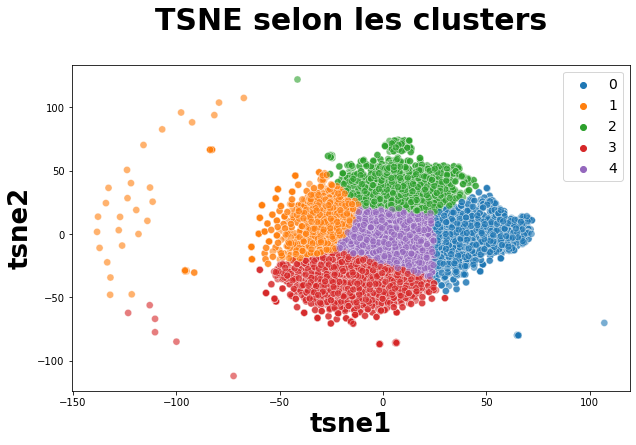

In [114]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=sift_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

<AxesSubplot:>

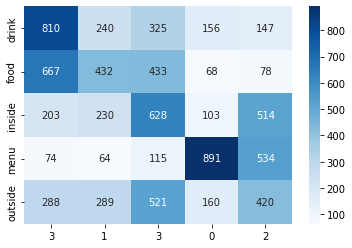

In [115]:
plt.figure(figsize = (6,4))
sns.heatmap(sift_cm, annot=True, cmap="Blues", fmt='g')

## 3.2. Avec Transfer Learning

### 3.2.1. Creation de features puis Clustering

In [116]:
with open("results/CV/transfer_tsne", "rb") as fp:
    transfer_tsne = pickle.load(fp)

In [117]:
with open("results/CV/transfer_cm", "rb") as fp:
    transfer_cm = pickle.load(fp)

In [118]:
labels_elements = {
    'Intérieur': 'inside',
    'Extérieur': 'outside',
    'Menu': 'menu',
    'Nourriture': 'food',
    'Boisson': 'drink',
}
@interact(element=labels_elements)
def choix_element(element):
    sns.scatterplot(x="tsne1", y="tsne2", data=transfer_tsne[transfer_tsne["class"]==element], color=colors[element], s=50, alpha=0.6)

    plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    plt.legend(prop={'size': 14}) 

    plt.show()

interactive(children=(Dropdown(description='element', options={'Intérieur': 'inside', 'Extérieur': 'outside', …

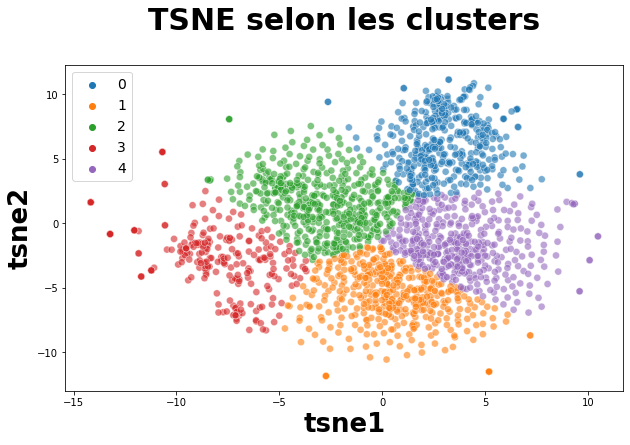

In [119]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=transfer_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

<AxesSubplot:>

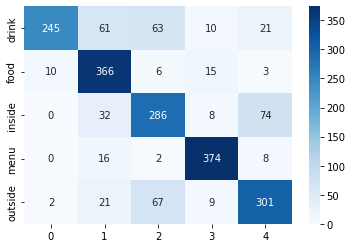

In [92]:
plt.figure(figsize = (6,4))
sns.heatmap(transfer_cm, annot=True, cmap="Blues", fmt='g')

### 3.2.2. Creation de features puis Clustering

In [107]:
from sklearn import metrics

In [94]:
transfer_classifier = load_model('results/transfer_classifier.h5')

In [99]:
with open("data/X_test", "rb") as fp:
    X_test = pickle.load(fp)

In [100]:
with open("data/y_test", "rb") as fp:
    y_test = pickle.load(fp)

In [101]:
# Evaluation du modèle
(eval_loss, eval_accuracy) = transfer_classifier.evaluate(X_test, y_test)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

13/13 [==============================] - 18s 1s/step - loss: 1.0102 - accuracy: 0.8950
[INFO] accuracy: 89.50%
[INFO] Loss: 1.010168194770813


In [103]:
y_pred_labels = transfer_classifier.predict(X_test)

13/13 [==============================] - 18s 1s/step


In [104]:
y_pred = [np.argmax(y) for y in y_pred_labels]

In [105]:
y_true = [np.argmax(y) for y in y_test]

In [109]:
print("ARI : ", metrics.adjusted_rand_score(y_true, y_pred))

ARI :  0.7609377545650835


<AxesSubplot:>

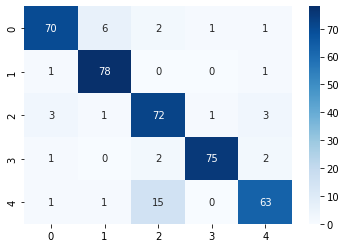

In [108]:
transfer_classifier_cm = metrics.confusion_matrix(y_true, y_pred)
plt.figure(figsize = (6,4))
sns.heatmap(transfer_classifier_cm, annot=True, cmap="Blues", fmt='g')